# ML-Agents Use SideChannels
<img src="https://raw.githubusercontent.com/Unity-Technologies/ml-agents/release_21_docs/docs/images/3dball_big.png" align="middle" width="435"/>

## Setup

In [1]:
#@title Install Rendering Dependencies { display-mode: "form" }
#@markdown (You only need to run this code when using Colab's hosted runtime)

import os
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

pro_bar = display(progress(0, 100), display_id=True)

try:
  import google.colab
  INSTALL_XVFB = True
except ImportError:
  INSTALL_XVFB = 'COLAB_ALWAYS_INSTALL_XVFB' in os.environ

if INSTALL_XVFB:
  with open('frame-buffer', 'w') as writefile:
    writefile.write("""#taken from https://gist.github.com/jterrace/2911875
XVFB=/usr/bin/Xvfb
XVFBARGS=":1 -screen 0 1024x768x24 -ac +extension GLX +render -noreset"
PIDFILE=./frame-buffer.pid
case "$1" in
  start)
    echo -n "Starting virtual X frame buffer: Xvfb"
    /sbin/start-stop-daemon --start --quiet --pidfile $PIDFILE --make-pidfile --background --exec $XVFB -- $XVFBARGS
    echo "."
    ;;
  stop)
    echo -n "Stopping virtual X frame buffer: Xvfb"
    /sbin/start-stop-daemon --stop --quiet --pidfile $PIDFILE
    rm $PIDFILE
    echo "."
    ;;
  restart)
    $0 stop
    $0 start
    ;;
  *)
        echo "Usage: /etc/init.d/xvfb {start|stop|restart}"
        exit 1
esac
exit 0
    """)
  !sudo apt-get update
  pro_bar.update(progress(10, 100))
  !sudo DEBIAN_FRONTEND=noninteractive apt install -y daemon wget gdebi-core build-essential libfontenc1 libfreetype6 xorg-dev xorg
  pro_bar.update(progress(20, 100))
  !wget http://security.ubuntu.com/ubuntu/pool/main/libx/libxfont/libxfont1_1.5.1-1ubuntu0.16.04.4_amd64.deb 2>&1
  pro_bar.update(progress(30, 100))
  !wget --output-document xvfb.deb http://security.ubuntu.com/ubuntu/pool/universe/x/xorg-server/xvfb_1.18.4-0ubuntu0.12_amd64.deb 2>&1
  pro_bar.update(progress(40, 100))
  !sudo dpkg -i libxfont1_1.5.1-1ubuntu0.16.04.4_amd64.deb 2>&1
  pro_bar.update(progress(50, 100))
  !sudo dpkg -i xvfb.deb 2>&1
  pro_bar.update(progress(70, 100))
  !rm libxfont1_1.5.1-1ubuntu0.16.04.4_amd64.deb
  pro_bar.update(progress(80, 100))
  !rm xvfb.deb
  pro_bar.update(progress(90, 100))
  !bash frame-buffer start
  os.environ["DISPLAY"] = ":1"
pro_bar.update(progress(100, 100))

### Installing ml-agents

In [2]:
try:
  import mlagents
  print("ml-agents already installed")
except ImportError:
  !python -m pip install -q mlagents==1.0.0
  print("Installed ml-agents")

ml-agents already installed


## Side Channel

SideChannels are objects that can be passed to the constructor of a UnityEnvironment or the `make()` method of a registry entry to send non Reinforcement Learning related data.
More information available [here](https://github.com/Unity-Technologies/ml-agents/blob/release_21_docs/docs/Python-API.md#communicating-additional-information-with-the-environment)





### Engine Configuration SideChannel
The [Engine Configuration Side Channel](https://github.com/Unity-Technologies/ml-agents/blob/release_21_docs/docs/Python-API.md#engineconfigurationchannel) is used to configure how the Unity Engine should run.
We will use the GridWorld environment to demonstrate how to use the EngineConfigurationChannel.

In [3]:
# -----------------
# This code is used to close an env that might not have been closed before
try:
  env.close()
except:
  pass
# -----------------

from mlagents_envs.registry import default_registry
env_id = "GridWorld"

# Import the EngineConfigurationChannel class
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel

# Create the side channel
engine_config_channel = EngineConfigurationChannel()

# Pass the side channel to the make method
# Note, the make method takes a LIST of SideChannel as input
env = default_registry[env_id].make(side_channels = [engine_config_channel])

# Configure the Unity Engine
engine_config_channel.set_configuration_parameters(target_frame_rate = 30)

env.reset()

# ...
# Perform experiment on environment
# ...

env.close()

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

### Environment Parameters Channel
The [Environment Parameters Side Channel](https://github.com/Unity-Technologies/ml-agents/blob/release_21_docs/docs/Python-API.md#environmentparameters) is used to modify environment parameters during the simulation.
We will use the GridWorld environment to demonstrate how to use the EngineConfigurationChannel.

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

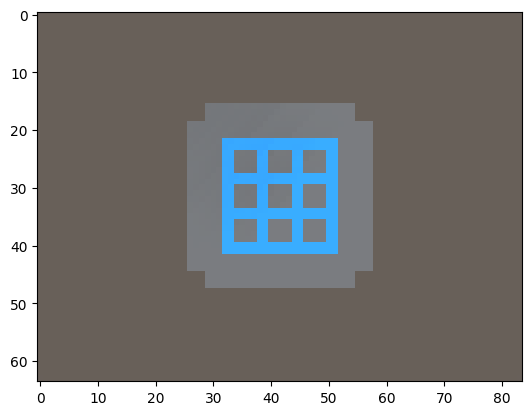

Increasing the dimensions of the grid from 5 to 7
Increasing the number of X from 1 to 5


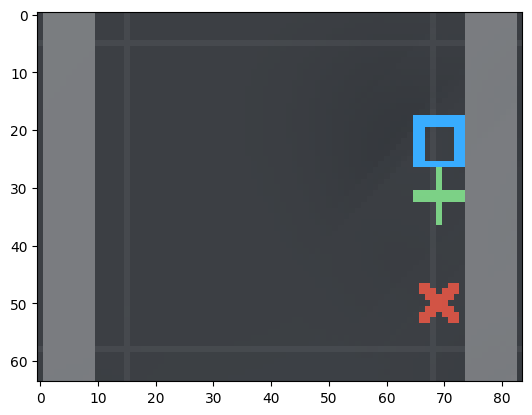

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# -----------------
# This code is used to close an env that might not have been closed before
try:
  env.close()
except:
  pass
# -----------------

from mlagents_envs.registry import default_registry
env_id = "GridWorld"

# Import the EngineConfigurationChannel class
from mlagents_envs.side_channel.environment_parameters_channel import EnvironmentParametersChannel

# Create the side channel
env_parameters = EnvironmentParametersChannel()

# Pass the side channel to the make method
# Note, the make method takes a LIST of SideChannel as input
env = default_registry[env_id].make(side_channels = [env_parameters])

env.reset()
behavior_name = list(env.behavior_specs)[0]

print("Observation without changing the environment parameters")
decision_steps, terminal_steps = env.get_steps(behavior_name)
plt.imshow(np.moveaxis(decision_steps.obs[0][0,:,:,:], 0, -1))
plt.show()

print("Increasing the dimensions of the grid from 5 to 7")
env_parameters.set_float_parameter("gridSize", 7)
print("Increasing the number of X from 1 to 5")
env_parameters.set_float_parameter("numObstacles", 5)

# Any change to a SideChannel will only be effective after a step or reset
# In the GridWorld Environment, the grid's dimensions can only change at reset
env.reset()


decision_steps, terminal_steps = env.get_steps(behavior_name)
plt.imshow(np.moveaxis(decision_steps.obs[0][0,:,:,:], 0, -1))
plt.show()



env.close()

### Creating your own Side Channels
You can send various kinds of data between a Unity Environment and Python but you will need to [create your own implementation of a Side Channel](https://github.com/Unity-Technologies/ml-agents/blob/release_21_docs/docs/Custom-SideChannels.md#custom-side-channels) for advanced use cases.
